In [2]:
# Refer to this part of the code: https://github.com/gitesei/willard-chandler/blob/master/WCIS_functions.py
import numpy as np
import pandas as pd
import mdtraj as md
from scipy.spatial import cKDTree
from skimage import measure
import sys
from time import time
import itertools
import matplotlib.pyplot as plt
def make_grid(box,mesh):
    ngrid = np.ceil(box / mesh).astype(int)
    grid_shape = tuple(ngrid.astype(int))
    spacing = box / ngrid
    xyz = []
    for i in range(3):
        xyz.append(np.linspace(0., box[i]-box[i]/ngrid[i], ngrid[i]))
    x, y, z = np.meshgrid(xyz[0], xyz[1], xyz[2], indexing='ij')
    grid = np.c_[x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)]
    return grid, spacing, grid_shape


def initialize(filename,top,mesh,alpha,molecules,nskip,layers):
    #load traj
    sel = ' or '.join(['name '+m for mol in molecules for m in mol.split(' ') if m[0]!='H'])
    traj = md.load_dcd(filename,top=top,
            atom_indices=top.top.select(sel))[nskip:]
    box = traj.unitcell_lengths.mean(0)  
    atom_indices=top.top.select(sel)

        #atom density distrubation along z axis
    #print(box)
    #print(traj.xyz[:,:,2])
    hist, edges = np.histogram(traj.xyz[:,:,2],bins=np.arange(0,box[2],1).astype(int))  
    #hist, edges = np.histogram(traj.xyz[:,:,2],bins=np.arange(0,box[2],0.1))  
    z = edges[:-1]+(edges[1]-edges[0])/2.
    hist = hist/(box[0]*box[1]*traj.n_frames)
    plt.plot(hist)
    z_min = np.floor(z[hist>hist.max()/2].min()).astype(int)
    z_max = np.ceil(z[hist>hist.max()/2].max()).astype(int)
    # max and min density biger than half density
    #z_min = np.floor(z[hist>hist.max()/2].min())
    #z_max = np.ceil(z[hist>hist.max()/2].max())
    #print(z_min)
    #print(z_max)
    #print("hist",hist)
    #print(z_min+2,z_max-2)
    # get the position where half density is (GBS point)
    level = 0.5*hist[np.logical_and(z>z_min+1,z<z_max-1)].mean()
    edges = np.arange(-1,z_max-z_min+1,mesh*0.1)
    z = edges[:-1]+(edges[1]-edges[0])/2.
    thetaedges = np.arange(0,181,2)
    theta = thetaedges[:-1]+(thetaedges[1]-thetaedges[0])/2.
    grid, spacing, grid_shape = make_grid(box,mesh)
    data = {}
    # initialization data
    for molecule in molecules:
        atoms = molecule.split(' ')
        if len(atoms)==1:
            print('rq',atoms[0])
            #data[atoms[0]] = {'upper': np.zeros(z.size), 'lower': np.zeros(z.size)} 
            data[atoms[0]] = {'upper': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros((len(layers)-1,theta.size)), all=np.empty(0), ndang=np.empty(0)), 
                              'lower': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros((len(layers)-1,theta.size)), all=np.empty(0), ndang=np.empty(0))}
        elif len(atoms)==3:
            for atom in atoms[::2]:
                data[atom] = {'upper': np.zeros(z.size), 'lower': np.zeros(z.size)}
            data[atoms[1]] = {'upper': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms[::2], theta=np.zeros((len(layers)-1,theta.size))), 
                              'lower': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms[::2], theta=np.zeros((len(layers)-1,theta.size)))}
        elif len(atoms)==2:
            data[atoms[0]] = {'upper': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros(theta.size), all=np.empty(0), ndang=np.empty(0)), 
                              'lower': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros(theta.size), all=np.empty(0), ndang=np.empty(0))}
            data[atoms[1]] = {'upper': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros((len(layers)-1,theta.size))), 
                              'lower': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros((len(layers)-1,theta.size)))}
    params = {"radius": 3*alpha,
             "scale": 2.*alpha**2,
             "factor": np.power(2.*np.pi*alpha**2,-3/2.),
             "box": box,
             "mesh": mesh,
             "bw": mesh*0.1,
             "n_frames": traj.n_frames+nskip,
             "spacing": spacing,
             "grid": grid,
             "grid_shape": grid_shape,
             "edges": edges,
             "theta": theta,
             "z": z,
             "sel": sel,
             "surface_area": np.empty(0),
             "surface_zstd": np.empty(0),
             "level": level,
             "layers": layers,
             "data": data}
    del traj
    return pd.Series(params)

def calc_profiles(frame,surface,params,label,sign,layers):
    box, edges, data, bw = params['box'], params['edges'], params['data'], params['bw']
    toM = 1. / (bw*box[0]*box[1]*6.022*0.1)
    verts, normals = surface
    tree = cKDTree(verts, boxsize=box)
    for atom, value in data.items():
        pos = frame.atom_slice(frame.top.select('name '+atom)).xyz[0]
        #pos = frame.atom_slice(frame.top.select('name O')).xyz[0]
        #print('pos',pos)
        _, ind = tree.query(pos, k=1)
        dist = (tree.data[ind,2] - pos[:,2])*sign
        if type(value[label]) == dict:
            hist, _ = np.histogram(dist,bins=edges,density=False)
            value[label]['conc'] += hist * toM
            if value[label]['theta'].ndim > 1:
            #    cosine(frame,dist,atom,normals[ind,:],value[label],sign,edges,toM,layers)
            #else:
                selOSN = frame.top.select('element O or element S')  # to 
                posOSN = frame.atom_slice(selOSN).xyz[0]
                _, indOSN = tree.query(posOSN, k=1)
                distOSN = (tree.data[indOSN,2] - posOSN[:,2])*sign
                mask = np.logical_and(dist>-.31,dist<.31)#rqz influence dangling number
                idx = np.asarray(frame.top.select('name O'))[mask]

                ind_surf = ind[mask]
                mask = np.logical_and(distOSN>-.8,distOSN<0.8)#rqz influence dangling number
                idxOSN = np.asarray(selOSN)[mask]
                #print('idx',idx)
                #print('idx',idx)
                #print('dist',dist)
                dangling(frame,value[label],sign,dist,distOSN,idx,idxOSN,normals[ind_surf,:])     
        else:
            # hist of density distrubation with distance from WCI
            hist, _ = np.histogram(dist,bins=edges,density=False)
            value[label] += hist * toM
def cosine(frame,dist,atom,normals,dictionary,sign,edges,toM,layers):
    selection_string = 'name O or name H1'
    pair1 = np.array(frame.top.select(selection_string)).reshape(-1,2)
    vec1 = md.compute_displacements(frame,pair).reshape(-1,3)
    selection_string = 'name O or name H2'
    pair2 = np.array(frame.top.select(selection_string)).reshape(-1,2)
    vec2 = md.compute_displacements(frame,pair2).reshape(-1,3)
    vec=vec1+vec2
    
    cosine = np.einsum('ij,ij->i',vec,normals) / np.linalg.norm(vec,axis=1)
    if atom=='C2':
        cosine = -cosine
    #hist, _ = np.histogram(dist,bins=edges,weights=cosine,density=False)
    cosine_sum, _ = np.histogram(dist,bins=edges,weights=cosine,density=False)
    bin_count, _ = np.histogram(dist, bins=edges)
    bin_count = np.where(bin_count == 0, 1, bin_count)
    cosine_avg = cosine_sum / bin_count
    hist=cosine_avg
    dictionary['cosine'] += hist * toM
    angle = np.arccos(np.clip(cosine,-1,1))/np.pi*180
    for i in range(len(layers)-1):
        mask = np.logical_and(dist>layers[i],dist<layers[i+1])
        hist, _ = np.histogram(angle[mask],bins=np.arange(0,181,2),density=False)
        dictionary['theta'][i] += hist

def cosine_back(frame,dist,atom,normals,dictionary,sign,edges,toM,layers):
    selection_string = 'name '+dictionary['pair'][0]+' or name '+dictionary['pair'][1]
    pair = np.array(frame.top.select(selection_string)).reshape(-1,2)
    vec = md.compute_displacements(frame,pair).reshape(-1,3)
    cosine = np.einsum('ij,ij->i',vec,normals) / np.linalg.norm(vec,axis=1)
    if atom=='C2':
        cosine = -cosine
    #hist, _ = np.histogram(dist,bins=edges,weights=cosine,density=False)
    cosine_sum, _ = np.histogram(dist,bins=edges,weights=cosine,density=False)
    bin_count, _ = np.histogram(dist, bins=edges)
    bin_count = np.where(bin_count == 0, 1, bin_count)
    cosine_avg = cosine_sum / bin_count
    hist=cosine_avg
    #pos = frame.atom_slice(frame.top.select('name H1')).xyz[0][:,2]
    #hist, _ = np.histogram(pos,bins=edges,weights=cosine,density=False)
    #z = edges[:-1]+(edges[1]-edges[0])/2.
    #plt.plot(z,hist)
    dictionary['cosine'] += hist * toM
    angle = np.arccos(np.clip(cosine,-1,1))/np.pi*180
    for i in range(len(layers)-1):
        mask = np.logical_and(dist>layers[i],dist<layers[i+1])
        hist, _ = np.histogram(angle[mask],bins=np.arange(0,181,2),density=False)
        dictionary['theta'][i] += hist

def dangling(frame,dictionary,sign,dist,distOSN,idx,idxOSN,normals):
    # idx:  O index near interface 
    #idxOSN: O index to define O-O distance and then for selecting dang OH 
    pair_ox = np.asarray(list(itertools.product(idx, idxOSN)))
    # remove pairs of same index
    pair_ox = pair_ox[np.std(pair_ox,axis=1)!=0]
    dist_ox = md.compute_distances(frame,pair_ox).reshape(idx.size,-1)
    h1o = np.c_[idx,idx+1]
    h2o = np.c_[idx,idx+2]
    # compute H-O vectors
    vec_h1o = md.compute_displacements(frame,h1o).reshape(-1,3)
    vec_h2o = md.compute_displacements(frame,h2o).reshape(-1,3)
    cosine_h1o = np.einsum('ij,ij->i',vec_h1o,normals) / np.linalg.norm(vec_h1o,axis=1)
    cosine_h2o = np.einsum('ij,ij->i',vec_h2o,normals) / np.linalg.norm(vec_h2o,axis=1)
    angle_h1o = np.arccos(np.clip(cosine_h1o,-1,1))/np.pi*180
    angle_h2o = np.arccos(np.clip(cosine_h2o,-1,1))/np.pi*180
    h1ox = np.c_[np.asarray(pair_ox)[:,0]+1,np.asarray(pair_ox)[:,0],np.asarray(pair_ox)[:,1]]
    h2ox = np.c_[np.asarray(pair_ox)[:,0]+2,np.asarray(pair_ox)[:,0],np.asarray(pair_ox)[:,1]]
    # compute H-O...O angles
    angle_h1ox = md.compute_angles(frame,h1ox).reshape(idx.size,-1)/np.pi*180
    angle_h2ox = md.compute_angles(frame,h2ox).reshape(idx.size,-1)/np.pi*180
    # selection of dangling OH based on R-beta definition (DOI: 10.1021/acs.jctc.7b00566)
    Rc = dist_ox<=.35
    
    beta1 = angle_h1ox<=50
    beta2 = angle_h2ox<=50
    angles_ho = np.append(angle_h1o[np.sum(beta1*Rc,axis=1)==0],angle_h2o[np.sum(beta2*Rc,axis=1)==0])
    #print(idx)   #index oxygen near interface 
    #print("ndang index1",idx[np.sum(beta1*Rc,axis=1)==0]) #dang index H1-O...O
    #print("ndang index2",idx[np.sum(beta2*Rc,axis=1)==0]) #dang index H2-O...O
    dictionary['ndang'] = np.append(dictionary['ndang'],angles_ho.size)
    dictionary['all'] = np.append(dictionary['all'],idx.size)
    hist, _ = np.histogram(angles_ho,bins=np.arange(0,181,2),density=False)
    dictionary['theta'] += hist

def find_isosurfaces(frame,params):
    radius,factor,scale,sel = params['radius'],params['factor'],params['scale'],params['sel']
    level = params['level']
    params['box'] = frame.unitcell_lengths[0]
    
    box=params['box']
    pos = frame.atom_slice(frame.top.select('name O')).xyz[0][:,2]
    hist, edges = np.histogram(pos,bins=np.arange(0,box[2],1).astype(int)) 
    z = edges[:-1]+(edges[1]-edges[0])/2.
    hist = hist/(box[0]*box[1])
    z_min = np.floor(z[hist>hist.max()/2].min()).astype(int)
    z_max = np.ceil(z[hist>hist.max()/2].max()).astype(int)
    #print("hist",hist)
    #print(z_min+2,z_max-2)
    # get the position where half density is (GBS point)
    level = 0.5*hist[np.logical_and(z>z_min+1,z<z_max-1)].mean()
    print('level',level)
    '''
    pos = frame.atom_slice(frame.top.select('name O')).xyz[0][:,2]
    pos = pos[(pos >= z_min-0.5) & (pos <= z_max+0.5)] 
    hist, edges = np.histogram(pos,bins=np.arange(z_min-0.5,z_max+0.5,0.1))  
    z = edges[:-1]+(edges[1]-edges[0])/2.
    hist = hist/(box[0]*box[1])
    plt.plot(z,hist)
    
    '''
    interface_to_air_width = 1.5  # interface to air width
    interface_to_bulk_width = 2.0  # interface to bulk width
    #print(z_min - interface_to_air_width,z_min + interface_to_bulk_width)
    #print(z_max - interface_to_bulk_width,z_max + interface_to_air_width)
    z_min_air = z_min - interface_to_air_width
    z_min_bulk = z_min + interface_to_bulk_width
    z_max_bulk = z_max - interface_to_bulk_width
    z_max_air = z_max + interface_to_air_width
    z_min_air = max(z_min_air, 0)
    z_max_air = min(z_max_air, box[2])
    params['grid'],params['spacing'],params['grid_shape'] = make_grid(params['box'],params['mesh'])
    grid,spacing,grid_shape,box = params['grid'],params['spacing'],params['grid_shape'],params['box']
    print(spacing)
    print(grid_shape)
    # limit z 
    pos = frame.atom_slice(frame.top.select('name O')).xyz[0]
    interface_to_air_width = 0.5  # interface to air width
    
    #print(z_min - interface_to_air_width,z_min + interface_to_bulk_width)
    #print(z_max - interface_to_bulk_width,z_max + interface_to_air_width)
    #pos = pos[((pos[:, 2] >= z_min - interface_to_air_width) & (pos[:, 2] <= z_min + interface_to_bulk_width)) |
    #      ((pos[:, 2] >= z_max - interface_to_bulk_width) & (pos[:, 2] <= z_max + interface_to_air_width))]
    #pos = pos[(pos[:, 2] >= z_min-interface_to_air_width) & (pos[:, 2] <= z_max+interface_to_air_width) ]   
    tree = cKDTree(grid,boxsize=box)
                
    # indeces of grid points within a radial distance from the particles
    indlist = tree.query_ball_point(pos, radius)

    # unwrapped list of lists
    indarray = np.asarray(list(itertools.chain.from_iterable(indlist)),dtype=int)

    # lenghts of the sublists in indlist
    lenarray = np.asarray([len(ind) for ind in indlist],dtype=int)

    # vector distance between particles and grid points
    dr = grid[indarray,:] - np.repeat(pos, lenarray, axis=0)

    # periodic boundary conditions in xy-plane
    cond = np.where(np.abs(dr) > box / 2.)
    dr[cond] -= np.sign(dr[cond])*box[cond[1]]
    # coarse grained density field
    dens = factor*np.exp( - np.linalg.norm(dr,ord=2,axis=1)**2 / scale )
    # densities at the same grid point are summed up
    field = pd.DataFrame(data={'index': indarray, 'dens': dens}).groupby('index').sum()
    # grid points with zero density are included in the dataframe
    new_index = pd.Index(range(grid.shape[0]), name="index")
    field = field.reindex(new_index,fill_value=0).values.reshape(grid_shape)
    
    verts, faces, normals, values = measure.marching_cubes(field, level, spacing=tuple(spacing))
    verts[:,:2] = verts[:,:2] + spacing[:2] / 2.
    cond_upper = verts[:,2]>box[2]/2
    
   
    upper = verts[cond_upper], normals[cond_upper]
    lower = verts[~cond_upper], normals[~cond_upper]
    
    params['surface_area'] = np.append(params['surface_area'],measure.mesh_surface_area(verts,faces)*0.5)
    params['surface_zstd'] = np.append(params['surface_zstd'],upper[0][:,2].std())
    params['surface_zstd'] = np.append(params['surface_zstd'],lower[0][:,2].std())
    return upper, lower



In [4]:
# define which trajectory you want to use for  analysis and name it as 'traj'
dcd_name="water_PMMA.dcd"
top_name="water_PMMA.pdb"
print(dcd_name,top_name)
traj=md.load_dcd(dcd_name,top_name)
#traj[100:200].save_dcd("1.dcd")
n_atoms=traj.n_atoms
n_frames = traj.n_frames
positions   = traj.xyz
box_lengths = traj.unitcell_lengths
box_angles  = traj.unitcell_angles
time        = traj.time
topology    = traj.topology
print('n_frames: ',n_frames)
OO = traj.topology.select('element O')
S = traj.topology.select('name S')
OH2 = traj.topology.select('name O')
H2 = traj.topology.select('name H2')
H1 = traj.topology.select('name H1')
print(OO,S,OH2,H1,H2)

water_PMMA.dcd water_PMMA.pdb
n_frames:  100
[40505 40508 40511 ... 67496 67499 67502] [    9    10    24 ... 40480 40494 40495] [40505 40508 40511 ... 67496 67499 67502] [40506 40509 40512 ... 67497 67500 67503] [40507 40510 40513 ... 67498 67501 67504]


rq O
radius                                                        0.9
scale                                                        0.18
factor                                                   2.351616
box                              [7.4456344, 7.450377, 12.189132]
mesh                                                          0.2
bw                                                           0.02
n_frames                                                       20
spacing         [0.19593774644952072, 0.19606255230150724, 0.1...
grid            [[0.0, 0.0, 0.0], [0.0, 0.0, 0.199821831750088...
grid_shape                                           (38, 38, 61)
edges           [-1.0, -0.98, -0.96, -0.94, -0.919999999999999...
theta           [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17...
z               [-0.99, -0.97, -0.95, -0.9299999999999999, -0....
sel                                                        name O
surface_area                                                   []
surfa

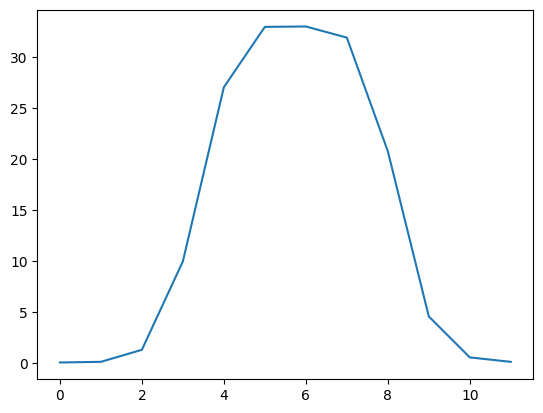

In [6]:
# prepare for WCI 
top = md.load(top_name)
params = initialize(filename=dcd_name,top=top,mesh=0.2,alpha=0.3,
            molecules=['O'],nskip=0,layers=[-0.1,0.1,0.3,0.5])

print(params)

In [7]:
upperS = []; lowerS = []
for i in range(0,params['n_frames'],1):
    frame = md.load_frame(dcd_name, index=i, top=top)
    upper, lower = find_isosurfaces(frame,params)
    upperS.append(upper[0])#upper vert upper
    lowerS.append(lower[0])#lower vert lower
    calc_profiles(frame,upper,params,label='upper',sign=1,layers=params['layers'])
    #calc_profiles(frame,lower,params,label='lower',sign=-1,layers=params['layers'])
    print('====',i)

level 16.533633817652497
[0.19593777 0.19606253 0.1998614 ]
(38, 38, 61)
==== 0
level 16.47654876540183
[0.19593777 0.19606253 0.19973015]
(38, 38, 61)
==== 1
level 16.616256919594242
[0.19593777 0.19606253 0.19979957]
(38, 38, 61)
==== 2
level 16.530629341218255
[0.19593777 0.19606253 0.19973975]
(38, 38, 61)
==== 3
level 16.50659352974429
[0.19593777 0.19606253 0.19987999]
(38, 38, 61)
==== 4
level 16.41946371315117
[0.19593777 0.19606253 0.19704617]
(38, 38, 62)
==== 5
level 16.634283778199716
[0.19593777 0.19606253 0.19986892]
(38, 38, 61)
==== 6
level 16.509598006178532
[0.19593777 0.19606253 0.19957961]
(38, 38, 61)
==== 7
level 16.58170544060042
[0.19593777 0.19606253 0.19971089]
(38, 38, 61)
==== 8
level 16.512602482612778
[0.19593777 0.19606253 0.19693607]
(38, 38, 62)
==== 9
level 16.470539812533342
[0.19593777 0.19606253 0.19709069]
(38, 38, 62)
==== 10
level 16.404441330979942
[0.19593777 0.19606253 0.19707795]
(38, 38, 62)
==== 11
level 16.42547266601966
[0.19593777 0.1960

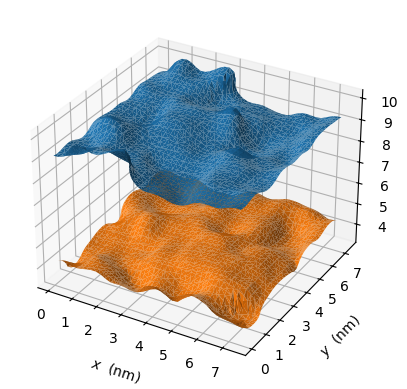

In [8]:

#plot interface to make sure it is resonable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
drwa_idx=3

ax.plot_trisurf(upperS[drwa_idx][:,0],upperS[drwa_idx][:,1],upperS[drwa_idx][:,2])
ax.plot_trisurf(lowerS[drwa_idx][:,0],lowerS[drwa_idx][:,1],lowerS[drwa_idx][:,2])
ax.set_xlabel('$x$  (nm)') 
ax.set_ylabel('$y$  (nm)')
ax.set_zlabel('$z$  (nm)')

for tick in ax.get_xaxis().get_major_ticks():
    tick.set_pad(.5)
for tick in ax.get_yaxis().get_major_ticks():
    tick.set_pad(.3)

plt.show()

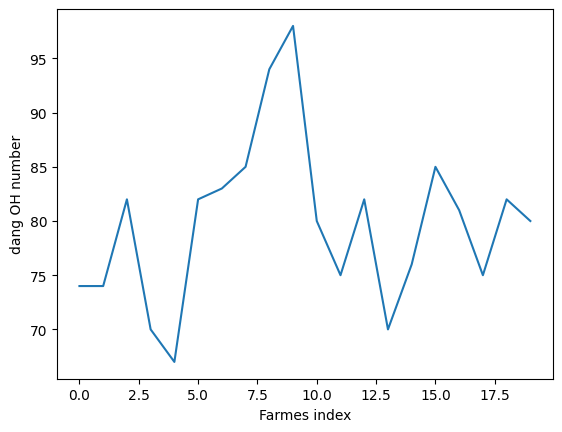

dangling OH ratio:  0.09473547848317654


In [9]:

plt.plot(params['data']['O']['upper']['ndang'])
plt.xlabel('Farmes index') 
plt.ylabel('dang OH number') 
#plt.legend()
plt.show()
print("dangling OH ratio: ",np.average(params['data']['O']['upper']['ndang']/params['data']['O']['upper']['all']))
